In [2]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from Pytorch_dataset import DimReduction_dataset
from Discharge_model import DimReduction_1
from early_stopping import EarlyStopping
from torch.utils.tensorboard import SummaryWriter

c:\Users\smcmlab4\Anaconda3\envs\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def train_model(model, writer,
                eol_train_loader, eol_test_loader,
                num_epochs=500,
                lr=1e-3,
                weight_decay=1e-3,
                cosine_period=20,
                min_lr=1e-6,
                delta_huber=1,
                patience=20):
                
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    optimizer = optim.AdamW(model.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay) # Adam with weight decay
    scheduler = CosineAnnealingLR(optimizer, T_max=cosine_period, eta_min=min_lr) # 依照cosine週期衰減
    criterion = nn.MSELoss() # combines advantages of both L1Loss and MSELoss

    start = time.time()

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    n_total_steps = len(eol_train_loader)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):

        ##### Training loop #####
        model.train() # prep model for training
        for i, (inputs, targets) in enumerate(eol_train_loader):
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
        # update lr
        scheduler.step()

        ##### Validation loop #####
        model.eval() # prep model for evaluation
        for inputs, targets in eol_test_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_losses.append(loss.item())
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f'[Epoch {epoch+1}/{num_epochs}] train_loss: {train_loss:.2f}, valid_loss: {valid_loss:.2f}')

        # tensorboard
        writer.add_scalar('train loss', train_loss, epoch * n_total_steps +i) # global step
        writer.add_scalar('valid loss', valid_loss, epoch * n_total_steps +i)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('Checkpoints/checkpoint.pt'))

    end = time.time()
    print(f'Training is end. Total trainig time: {(end-start)/60:.1f} minutes')

    return  model, avg_train_losses, avg_valid_losses

def loss_plot(avg_train_losses, avg_test_losses):
    plt.figure()
    plt.plot(avg_train_losses, 'r-', label='train')
    plt.plot(avg_test_losses, 'b-', label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('recorded loss')
    plt.legend()
    plt.show()


from torchmetrics.functional import mean_absolute_percentage_error, mean_squared_error

def model_evaluate(eol_model, batch_size=32, model_num=0, t_norm=False, set_code=''):
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    # load train data
    eol_train_dataset = DimReduction_dataset(train=True, pred_target='EOL', norm=True, set_code=set_code)
    eol_train_loader = DataLoader(eol_train_dataset, batch_size=92, shuffle=True)

    # load test dataDataLoader(eol_train_dataset, batch_size=batch_size, shuffle=False)
    eol_test_dataset = DimReduction_dataset(train=False, pred_target='EOL', norm=True, set_code=set_code)
    eol_test_loader = DataLoader(eol_test_dataset, batch_size=23, shuffle=True)

    eol_model = eol_model.to(device).eval()
    train_rmse_lst = []
    test_rmse_lst = []
    train_mape_lst = []
    test_mape_lst = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(eol_train_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = eol_model(inputs)

            mape_train = mean_absolute_percentage_error(outputs, targets.view(-1, 1).cuda())
            rmse_train = mean_squared_error(outputs, targets.view(-1, 1).cuda(), squared=False)
            
            train_rmse_lst.append(rmse_train.item())
            train_mape_lst.append(mape_train.item())
            if i == 0:
                plt.plot(outputs.cpu(), targets, 'ro', markersize=2.5, label='train')
            else:
                plt.plot(outputs.cpu(), targets, 'ro', markersize=2.5)
        print(f'Training set|RMSE: {np.average(train_rmse_lst):.2f}, MAPE: {np.average(train_mape_lst):.2f}')
        # print(train_rmse_lst)

        for i, (inputs, targets) in enumerate(eol_test_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = eol_model(inputs)
            
            mape_test = mean_absolute_percentage_error(outputs, targets.view(-1, 1).cuda())
            rmse_test = mean_squared_error(outputs, targets.view(-1, 1).cuda(), squared=False)
            
            test_rmse_lst.append(rmse_test.item())
            test_mape_lst.append(mape_test.item())
            # plot
            if i == 0:
                plt.plot(outputs.cpu(), targets, 'bo', markersize=2.5, label='valid')
            else:
                plt.plot(outputs.cpu(), targets, 'bo', markersize=2.5)
        print(f'Testing set|RMSE: {np.average(test_rmse_lst):.2f}, MAPE: {np.average(test_mape_lst):.2f}')
        # print(test_rmse_lst)

        plt.title('EOL model_'+str(model_num))
        plt.plot([0,2000], [0,2000], 'k--', linewidth=1.0)
        plt.xlabel('predicted')
        plt.ylabel('ground truth')
        plt.legend()
        plt.savefig('Figures/eol_model'+str(model_num)+'.jpg')



(9200, 4, 500)
(2300, 4, 500)
cuda is available
[Epoch 1/500] train_loss: 76169.07, valid_loss: 75818.31
Validation loss decreased (inf --> 75818.310330).  Saving model ...
[Epoch 2/500] train_loss: 25968.07, valid_loss: 35979.02
Validation loss decreased (75818.310330 --> 35979.019762).  Saving model ...
[Epoch 3/500] train_loss: 22433.27, valid_loss: 25444.03
Validation loss decreased (35979.019762 --> 25444.033000).  Saving model ...
[Epoch 4/500] train_loss: 18685.45, valid_loss: 33472.71
EarlyStopping counter: 1 out of 50
[Epoch 5/500] train_loss: 16381.36, valid_loss: 46265.78
EarlyStopping counter: 2 out of 50
[Epoch 6/500] train_loss: 14746.68, valid_loss: 51530.01
EarlyStopping counter: 3 out of 50
[Epoch 7/500] train_loss: 13305.46, valid_loss: 30821.98
EarlyStopping counter: 4 out of 50
[Epoch 8/500] train_loss: 11457.80, valid_loss: 32794.10
EarlyStopping counter: 5 out of 50
[Epoch 9/500] train_loss: 10041.31, valid_loss: 34393.51
EarlyStopping counter: 6 out of 50
[Epoch 

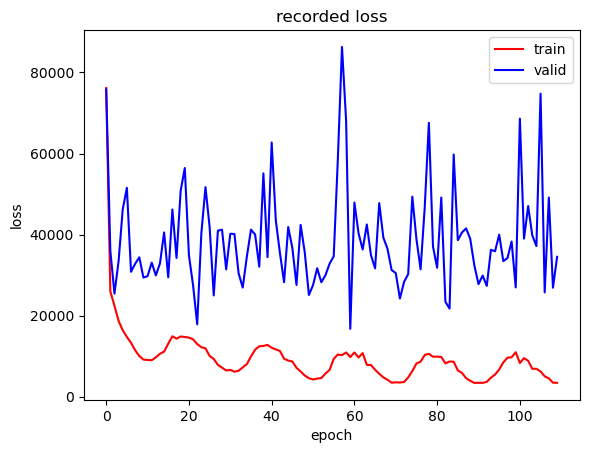

In [3]:
# load dataset
batch_size=32

eol_train_dataset = DimReduction_dataset(train=True, pred_target='EOL', norm=True, set_code='seed0')
eol_test_dataset = DimReduction_dataset(train=False, pred_target='EOL', norm=True, set_code='seed0')

eol_train_loader = DataLoader(eol_train_dataset, batch_size=batch_size, shuffle=True)
eol_test_loader = DataLoader(eol_test_dataset, batch_size=batch_size, shuffle=True)

# TensorBoard
writer = SummaryWriter('runs/eol_model1')
# load model
model_eol = DimReduction_1(in_ch=4, out_ch=1).cuda()

model, train_loss, valid_loss = train_model(model_eol, writer, eol_train_loader, eol_test_loader,
                                            patience=50, lr=1e-2, cosine_period=10, min_lr=1e-5, weight_decay=5*1e-2)

file = 'Model/eol_model1.pth'
torch.save(model, file)
print(file)

loss_plot(train_loss, valid_loss)

In [5]:
model_evaluate(model, model_num=1)

NameError: name 'model' is not defined